In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import sklearn.metrics.pairwise as pairwise

In [2]:

NUM_TAGS_USED = 100

tagDictionary = {}
idCounter = 0

data = pd.read_table('data/tags.dat', delimiter='::', engine='python')
data = data.drop(columns=['timestamp'])
data['tag'] = data['tag'].astype(str).str.lower().str.strip()
tags = sorted(data['tag'].unique())
used_tags = data['tag'].value_counts().index.tolist()[:NUM_TAGS_USED]
data = data[data['tag'].isin(used_tags)]

tags = sorted(data['tag'].unique())
tagDictionary = {tag: i for i, tag in enumerate(tags)}
data['tagID'] = (data['tag'].map(tagDictionary)).astype(int)

data['userID'] = data['userID'].astype(int)
data['movieID'] = data['movieID'].astype(int)

validUserIDs = np.argsort(sorted(data['userID'].unique()))
validUserIDMappings = {userID: validUserIDs[i] for i, userID in enumerate(data['userID'].unique())}
data['userID'] = data['userID'].map(validUserIDMappings).astype(int)

validMovieIDs = np.argsort(sorted(data['movieID'].unique()))
validMovieIDMappings = {movieID: validMovieIDs[i] for i, movieID in enumerate(data['movieID'].unique())}
data['movieID'] = data['movieID'].map(validMovieIDMappings).astype(int)

numTags = len(data['tag'].unique())
numUsers = len(data['userID'].unique())
numMovies = len(data['movieID'].unique())

In [3]:
invertedTagDictionary = {v: k for k,v in tagDictionary.iteritems()}

In [4]:
data.to_csv('reduced_data.csv')

In [5]:
def normalize_R(R_input):
    numRows = np.shape(R_input)[0]
    numCols = np.shape(R_input)[1]
    sumOverRows = np.sum(R_input, axis=0).reshape((1,numCols))
    sumOverCols = np.sum(R_input, axis=1).reshape((numRows,1))
    print(np.shape(sumOverRows*sumOverCols))
    return np.divide(R_input, np.sqrt(sumOverCols*sumOverRows))

In [6]:
Rut = np.zeros((numUsers, numTags))
def build_Rut():
    for i, row in data.iterrows():
        userID = row['userID']
        tagID = row['tagID']
        Rut[userID][tagID] += 1

build_Rut()
Rut = normalize_R(Rut)

(1818, 100)


In [7]:

Rud = np.zeros((numUsers, numMovies))

def build_Rud():
    for i, row in data.iterrows():
        userID = row['userID']
        movieID = row['movieID']
        Rud[userID][movieID] = 1

build_Rud()
print Rud

[[ 1.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [8]:
Rtd = np.zeros((numTags, numMovies))
Rtd_binary = np.zeros((numTags, numMovies))
W_dict = collections.defaultdict(set)

def build_Rtd():
    for i, row in data.iterrows():
        tagID = row['tagID']
        movieID = row['movieID']
        W_dict[movieID].add(tagID)
        Rtd[tagID][movieID] += 1
        Rtd_binary[tagID][movieID] = 1
build_Rtd()
Rtd = normalize_R(Rtd)
    

(100, 5374)


In [9]:
W = pairwise.pairwise_distances(Rtd_binary.T, metric='jaccard')
W = np.ones(W.shape) - W
print(W)
print (W.shape)


/Users/Rifath/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


[[ 1.          0.06666667  0.07142857 ...,  0.14285714  0.          0.        ]
 [ 0.06666667  1.          0.         ...,  0.          0.          0.        ]
 [ 0.07142857  0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.14285714  0.          0.         ...,  1.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          1.          1.        ]]
(5374, 5374)


In [10]:
alpha = 0.1
beta = 0.7
gamma = 0.1
eta = 0.1

In [11]:
def D_sumrows(R):
    D = np.sum(R, axis=1)
    D = np.diag(D)
    return D


D_ut = D_sumrows(Rut)
D_tu = D_sumrows(Rut.T)

D_td = D_sumrows(Rtd)
D_dt = D_sumrows(Rtd.T)

D_ud = D_sumrows(Rud)
D_du = D_sumrows(Rud.T)

D = D_sumrows(W)

L = D - W

elementsDict = {}

def buildLprime():
    elementsDict[(0,0)] = alpha*D_ut + gamma*D_ud
    elementsDict[(0, 1)] = -alpha*Rut
    elementsDict[(0, 2)] = -gamma*Rud
    elementsDict[(1,0)] = -alpha*Rut.T
    elementsDict[(1,1)] = alpha*D_tu + beta*D_td
    elementsDict[(1,2)] = -beta*Rtd
    elementsDict[(2, 0)] = -gamma*Rud.T
    elementsDict[(2, 1)] = -beta*Rtd.T
    elementsDict[(2, 2)] = beta*D_dt + gamma*D_du + eta*L
    
    row1 = np.concatenate((elementsDict[(0,0)], elementsDict[(0, 1)], elementsDict[(0, 2)]), axis=1)
    row2 = np.concatenate((elementsDict[(1,0)], elementsDict[(1, 1)], elementsDict[(1, 2)]), axis=1)
    row3 = np.concatenate((elementsDict[(2,0)], elementsDict[(2, 1)], elementsDict[(2, 2)]), axis=1)
    
    return np.concatenate((row1, row2, row3), axis=0)


L_prime = buildLprime()

In [12]:
def buildDprime():
    d1 = elementsDict[(0, 0)]
    d2 = elementsDict[(1, 1)]
    d3 = beta*D_dt + gamma*D_du + eta*D
    
    row1 = np.concatenate((d1, np.zeros((numUsers, numTags)), np.zeros((numUsers, numMovies))), axis=1)
    row2 = np.concatenate((np.zeros((numTags, numUsers)), d2, np.zeros((numTags, numMovies))), axis=1)
    row3 = np.concatenate((np.zeros((numMovies, numUsers)), np.zeros((numMovies, numTags)), d3),axis=1)
    
    return np.concatenate((row1, row2, row3), axis=0)

D_prime = buildDprime()

In [13]:
w, v = np.linalg.eigh(L_prime)
print w
print v

[ -5.56260433e-15   9.58001416e-02   9.64174349e-02 ...,   7.49765610e+01
   8.24809674e+01   9.47250184e+01]
[[ -1.17105332e-02  -1.30063636e-04   1.21537135e-04 ...,  -1.07459582e-07
    9.04611817e-08  -7.74190472e-08]
 [ -1.17105332e-02  -1.02595533e-03   1.07794952e-03 ...,   2.30123808e-06
    4.09224353e-08   1.39350474e-06]
 [ -1.17105332e-02   5.42949594e-02   2.12254793e-04 ...,  -7.70472555e-09
    3.35899521e-09  -3.69726125e-09]
 ..., 
 [ -1.17105332e-02  -6.84370166e-05   7.01991037e-05 ...,   7.22745018e-06
   -8.87614780e-06   8.33617110e-06]
 [ -1.17105332e-02  -2.76256534e-05   7.89284157e-05 ...,   1.20981345e-05
   -3.05776526e-06   6.62175804e-06]
 [ -1.17105332e-02  -2.76256534e-05   7.89284157e-05 ...,   1.20981345e-05
   -3.05776526e-06   6.62175804e-06]]


In [70]:
K = 50
H = v[:, 1:(K+1)]
print H
print H.shape

[[ -1.30063636e-04   1.21537135e-04  -1.70176977e-04 ...,  -2.65981815e-05
   -2.37111021e-05  -3.51994177e-05]
 [ -1.02595533e-03   1.07794952e-03  -1.85394417e-03 ...,  -2.92346825e-02
   -8.49331353e-03  -3.94121223e-02]
 [  5.42949594e-02   2.12254793e-04  -1.48233537e-03 ...,   1.86833671e-03
   -7.07284702e-04   2.49542488e-03]
 ..., 
 [ -6.84370166e-05   7.01991037e-05  -8.13212845e-05 ...,   2.49968884e-05
    6.91950970e-06   5.72779572e-06]
 [ -2.76256534e-05   7.89284157e-05  -1.12458454e-04 ...,  -7.00126405e-05
   -1.85709228e-05  -8.36602295e-05]
 [ -2.76256534e-05   7.89284157e-05  -1.12458454e-04 ...,  -7.00126405e-05
   -1.85709228e-05  -8.36602295e-05]]
(7292, 50)


In [71]:
H_rows = np.shape(H)[0]

In [72]:
M = H[H_rows-numMovies:,:]

In [73]:
print(M.shape)

(5374, 50)


In [74]:
print(numMovies)

5374


In [75]:
print M[100]

[ -7.16155890e-05   7.07873441e-05  -1.00396593e-04   9.73329458e-05
  -9.12937222e-05  -4.63109141e-05   2.05849973e-07  -4.06339431e-16
  -8.42276741e-06   6.23321939e-05  -4.61169148e-05  -3.99816006e-06
  -4.72171369e-05  -3.41775544e-05   1.69401887e-15   3.52923251e-05
  -1.75090133e-06   5.07101507e-05  -3.44187420e-05   2.32661945e-06
   4.06113068e-08  -1.93035740e-05   2.15564415e-05   9.19347610e-06
  -2.10634057e-05  -2.98410459e-05  -5.24804537e-05   2.70629002e-05
   1.39148720e-05  -4.82014761e-06   4.84706152e-06  -3.00966765e-05
  -1.02688590e-05   1.38141538e-05  -2.48517135e-05  -9.06466485e-06
  -5.18175120e-05  -6.03006444e-05  -3.13225915e-05   4.57320283e-05
   2.18841905e-05   1.99678977e-05  -2.56687260e-05  -5.02357269e-05
  -7.55207904e-05  -4.77080069e-06   2.62673370e-05  -2.09866053e-05
  -1.12309182e-05  -2.82336624e-05]


In [76]:
invertedMovieIDS = {v: k for k,v in validMovieIDMappings.iteritems()}

In [77]:
M_sim = pairwise.pairwise_distances(M, metric='cosine')
M_sim = np.ones(M_sim.shape) - M_sim

In [91]:
movies_data = pd.read_table('data/movies.dat', delimiter='::', engine='python')
movies_data['movieID'] = movies_data['movieID'].astype(int)
movies_data['movieName'] = movies_data['movieName'].astype(str)
movies_data['tags'] = movies_data['tags'].astype(str)

movieIDToName = {}
movieIDToTags = {}
for i, row in movies_data.iterrows():
    movieIDToName[row['movieID']] = row['movieName']
    movieIDToTags[row['movieID']] = row['tags']



for i in xrange(len(M_sim)):
    row = M_sim[i]
    mostSimilarMovieID = np.argsort(row)[-2]
    
    mostSimilarMovieActualID = invertedMovieIDS[mostSimilarMovieID]
    actualCurrentID = invertedMovieIDS[i]
    #print "Movie: ", movieIDToName[actualCurrentID], " is most similar to ", movieIDToName[mostSimilarMovieActualID], i, mostSimilarMovieID
    #print "Tags for Movie:", movieIDToTags[actualCurrentID], "  Tags for most similar Movie: ", movieIDToTags[mostSimilarMovieActualID]
    #print '\n'

    
    

In [81]:
M.shape

(5374, 50)

In [82]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

M = H[H_rows-numMovies:,:]
T = H[numUsers:H_rows-numMovies,:]

def fit_pca(matrix, title):
    pca = PCA(n_components=2)
    pca.fit(matrix)
    firstComponent = pca.components_[0,:]
    secondComponent = pca.components_[1,:]
    x = []
    y = []
    for row in matrix:
        firstCoordinate = np.dot(firstComponent, row)
        secondCoordinate = np.dot(secondComponent, row)
        x.append(firstCoordinate)
        y.append(secondCoordinate)
    plt.figure()
    plt.plot(x, y, 'b.')
    plt.xlabel("Value of the projection onto first component")
    plt.ylabel("Value of the projection onto second component")
    plt.title(title)
    plt.show()


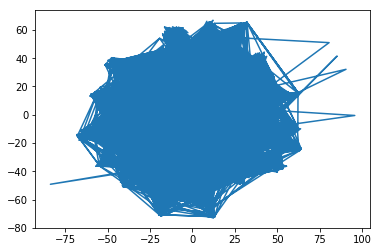

In [83]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(M)
x,y = [],[]
for row in X_embedded:
    
    x.append(row[0])
    y.append(row[1])

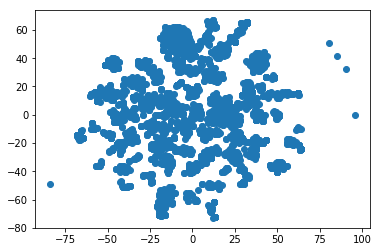

In [86]:
plt.scatter(x, y)

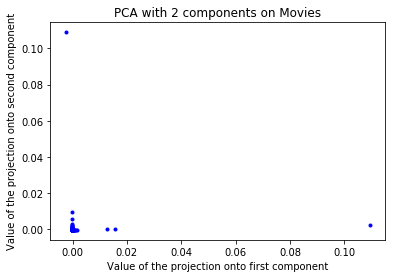

In [58]:
fit_pca(M, "PCA with 2 components on Movies")

In [46]:
T

array([[ -7.54530498e-05,   5.88146288e-05,  -8.23677486e-05, ...,
         -3.42541544e-06,   4.96175297e-07,   6.22972212e-15],
       [ -9.73560367e-05,   9.65425862e-05,  -1.39068082e-04, ...,
         -7.33847564e-06,   3.37960423e-04,   9.41505505e-14],
       [ -7.64797347e-05,   6.71290160e-05,  -7.87810798e-05, ...,
         -2.49434376e-05,   1.13274122e-05,  -1.30662724e-14],
       ..., 
       [ -9.94539731e-05,   9.14663046e-05,  -1.31165928e-04, ...,
          2.91471042e-05,   7.71817063e-06,  -5.92415327e-15],
       [ -9.21584132e-05,   6.75381330e-05,  -1.10183885e-04, ...,
          1.08778673e-05,   9.24233314e-06,   6.09627259e-15],
       [ -1.02307956e-04,   1.04619125e-04,  -1.57167966e-04, ...,
          9.44456577e-06,   5.45537852e-06,  -2.34877942e-15]])